---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import download
import string
from gensim.models import CoherenceModel
import numpy as np
import networkx as nx

In [136]:
# Load the CSV file
file_path = '../../data/processed-data/merged_data.csv'
data = pd.read_csv(file_path)

## Univariate Analysis for Gender-Related Data

### Univariate Analysis for Total Score

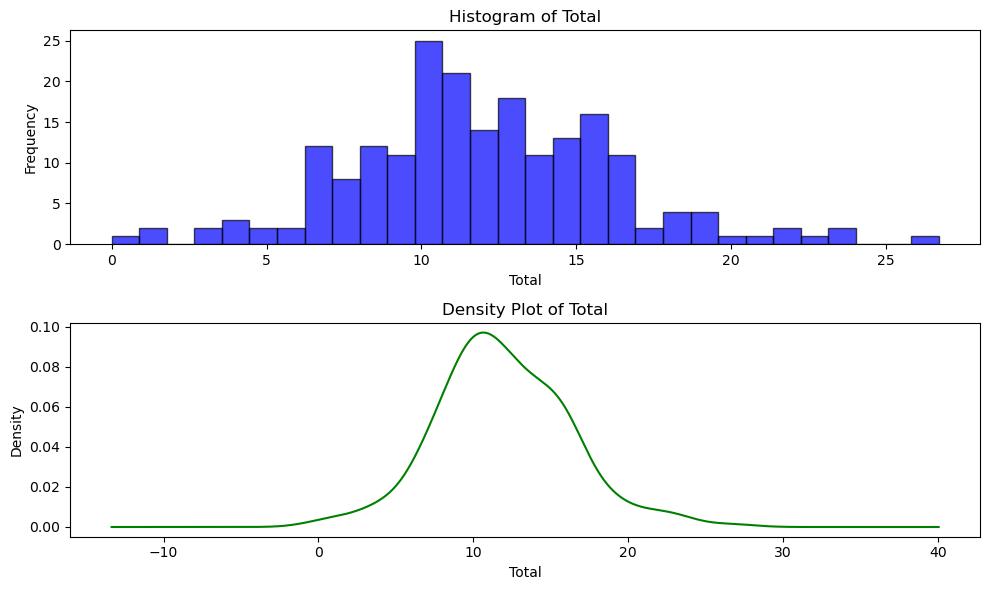

count    202.000000
mean      11.930198
std        4.258177
min        0.000000
25%        9.400000
50%       11.550000
75%       14.700000
max       26.700000
Name: Total, dtype: float64

In [13]:
# Filter for the "Total" column and ensure it is numeric
data['Total'] = pd.to_numeric(data['Total'], errors='coerce')

# Calculate summary statistics for "Total"
summary_stats = data['Total'].describe()

# Visualize distribution using histograms and density plots
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(data['Total'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Total')
plt.xlabel('Total')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(2, 1, 2)
data['Total'].dropna().plot(kind='density', color='green')
plt.title('Density Plot of Total')
plt.xlabel('Total')

plt.tight_layout()
plt.show()

summary_stats

The maximum possible Total Score is 100, representing the highest performance in terms of gender equality and respect. This includes aspects such as working environment, compensation and benefits, and the prevention of violence and harassment.

**Statistical Summary**:
1. Count: 202 companies are included in the dataset.
2. Mean: The average Total Score is 11.93, which is far below from the maximum possible score of 100.
3. Standard Deviation: The scores have a spread of 4.26, indicating moderate variability in performance.
4. Minimum: The lowest score is 0, suggesting that some companies performed extremely poorly in gender equality measures.
5. Maximum: The highest score in the dataset is 26.70, far below the theoretical maximum of 100, which highlights the overall poor performance.

**Visual Observations**:
1. Histogram: The majority of the scores are clustered around the 10-15 range, with the frequency peaking near the mean (11.93). Very few companies scored above 20, indicating that achieving high scores is uncommon in this dataset.
2. Density Plot: The density curve is slightly skewed to the right, with a long tail extending towards higher scores, highlighting a few outliers with better performance. The peak of the density aligns closely with the mean and median, reinforcing the clustering of scores in the mid-range.

**Key Insights**:

The low mean, median, and maximum values underscore that most companies in the dataset are performing poorly on gender equality and respect indicators. There is a significant opportunity for improvement, as no company has achieved scores close to the theoretical maximum.

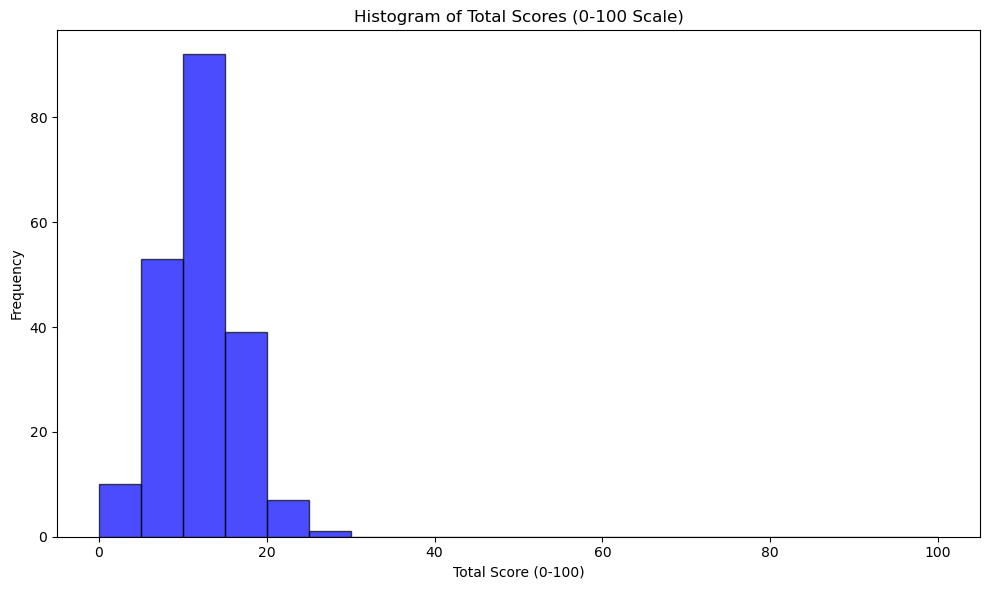

In [14]:
# Histogram with the scale set to 0-100
plt.figure(figsize=(10, 6))

# Histogram with fixed range 0-100
plt.hist(data['Total'].dropna(), bins=20, range=(0, 100), alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Total Scores (0-100 Scale)')
plt.xlabel('Total Score (0-100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


When we put the data into a scale of 0-100 (the theoritical scale), we can see the overall performance of the companies in a more clear way:

**Visual Observations**:
1. Data Concentration: The majority of the Total Scores fall well below the midpoint of the 0-100 scale, with most scores concentrated between 0 and 30.
2. Lack of High Scores: No data points exceed a score of 30 out of 100, indicating that companies in the dataset perform significantly below the potential benchmark.

**Key Insights**:

The visualization starkly highlights the underperformance of these companies in meeting gender equality standards. This may point to systemic issues or a lack of substantial initiatives toward achieving higher scores.

### Univariate Analysis for CEO Gender

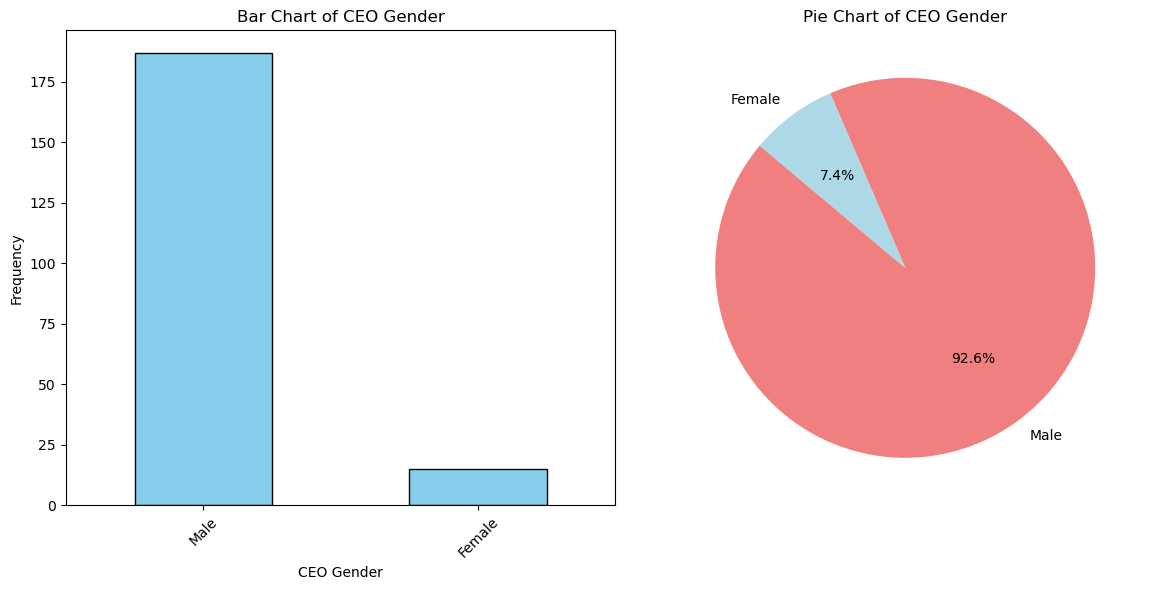

CEO Gender
Male      187
Female     15
Name: count, dtype: int64

In [15]:
# Frequency counts for "CEO Gender"
ceo_gender_counts = data['CEO Gender'].value_counts()

# Visualizing the distribution using bar chart and pie chart
plt.figure(figsize=(12, 6))

# Bar Chart
plt.subplot(1, 2, 1)
ceo_gender_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of CEO Gender')
plt.xlabel('CEO Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Pie Chart
plt.subplot(1, 2, 2)
ceo_gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Pie Chart of CEO Gender')
plt.ylabel('')  # Removing the y-label for a cleaner pie chart

plt.tight_layout()
plt.show()

ceo_gender_counts

The data reveals a significant imbalance in CEO gender representation:

**Visual Observations**:

The majority of CEOs in the dataset are male (92.6%), while only a small percentage (7.4%) are female. The bar and pie charts both illustrate this stark gender gap, emphasizing the dominance of male CEOs across companies.

**Key Insights**:

This disparity showed in the charts highlights a clear underrepresentation of women in top leadership positions. Coupled with the low Total Scores observed for gender equality indicators, it is evident that most companies are underperforming in fostering a more equitable and inclusive environment. This imbalance underscores the need for stronger initiatives and actionable commitments to promote gender diversity at the leadership level.

## Bivariate and Multivariate Analysis

### Relationships Between Financial Indicators and Total Score

First, we use Assets to standardize the financial indicators (except for EarningsPerShareBasic, since it is already a ratio rather than an amount), ensuring they are not influenced by company size in the subsequent analysis.

In [17]:
# Standardizing financial indicators by total assets
financial_columns = [
    'NetIncomeLoss (k)', 
    'OperatingIncomeLoss (k)', 
    'GrossProfit (k)', 
    'ComprehensiveIncomeNetOfTax (k)', 
    'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
    'EntityPublicFloat (k)', 
    'AllocatedShareBasedCompensationExpense (k)', 
    'CashAndCashEquivalentsAtCarryingValue (k)', 
    'AccountsReceivableNetCurrent (k)'
]

data['Assets (k)'] = pd.to_numeric(data['Assets (k)'], errors='coerce')

# Avoid division by zero or null assets
data['Assets (k)'] = data['Assets (k)'].replace(0, pd.NA)

# Standardize each financial column by Total Assets
for col in financial_columns:
    standardized_col = f"{col}_PerAssets"
    data[standardized_col] = data[col] / data['Assets (k)']

# Display the standardized columns for review
data[[f"{col}_PerAssets" for col in financial_columns]].head()

,NetIncomeLoss (k)_PerAssets,OperatingIncomeLoss (k)_PerAssets,GrossProfit (k)_PerAssets,ComprehensiveIncomeNetOfTax (k)_PerAssets,RevenueFromContractWithCustomerExcludingAssessedTax (k)_PerAssets,EntityPublicFloat (k)_PerAssets,AllocatedShareBasedCompensationExpense (k)_PerAssets,CashAndCashEquivalentsAtCarryingValue (k)_PerAssets,AccountsReceivableNetCurrent (k)_PerAssets
0,0.141692,0.182959,0.328574,0.161306,0.543072,3.671740,NaN,0.180449,0.127569
1,-4.370164,-7.375983,NaN,-4.391481,0.367819,0.626670,0.001002,0.010744,0.055107
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.025766,NaN,NaN,0.041853,0.354137,1.733026,0.003549,0.114589,NaN
4,0.127129,0.088929,0.192701,0.144526,0.933090,0.549736,0.003650,0.079562,NaN


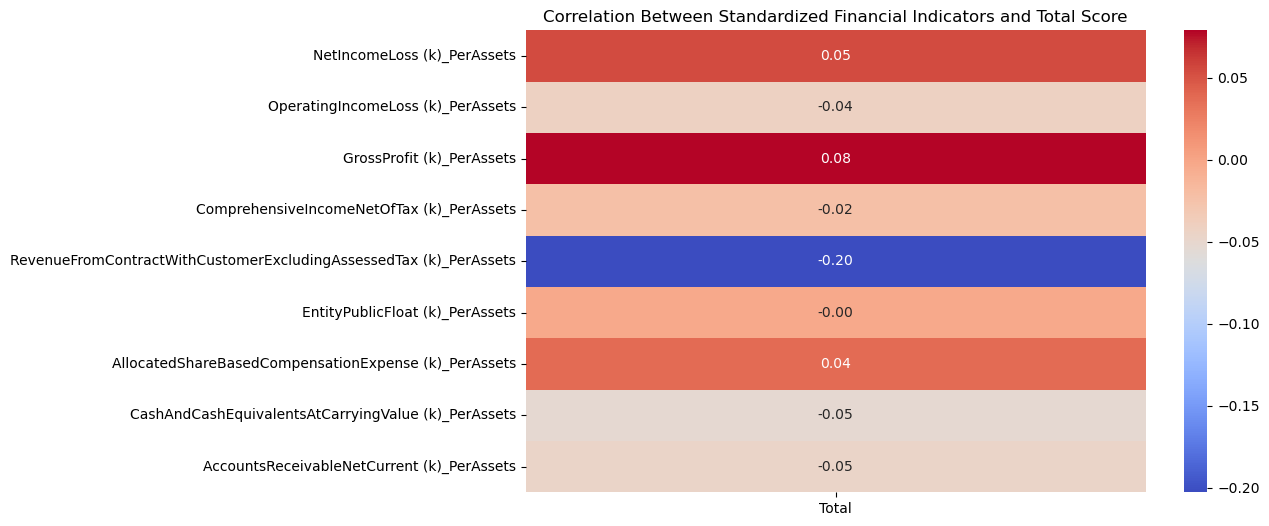

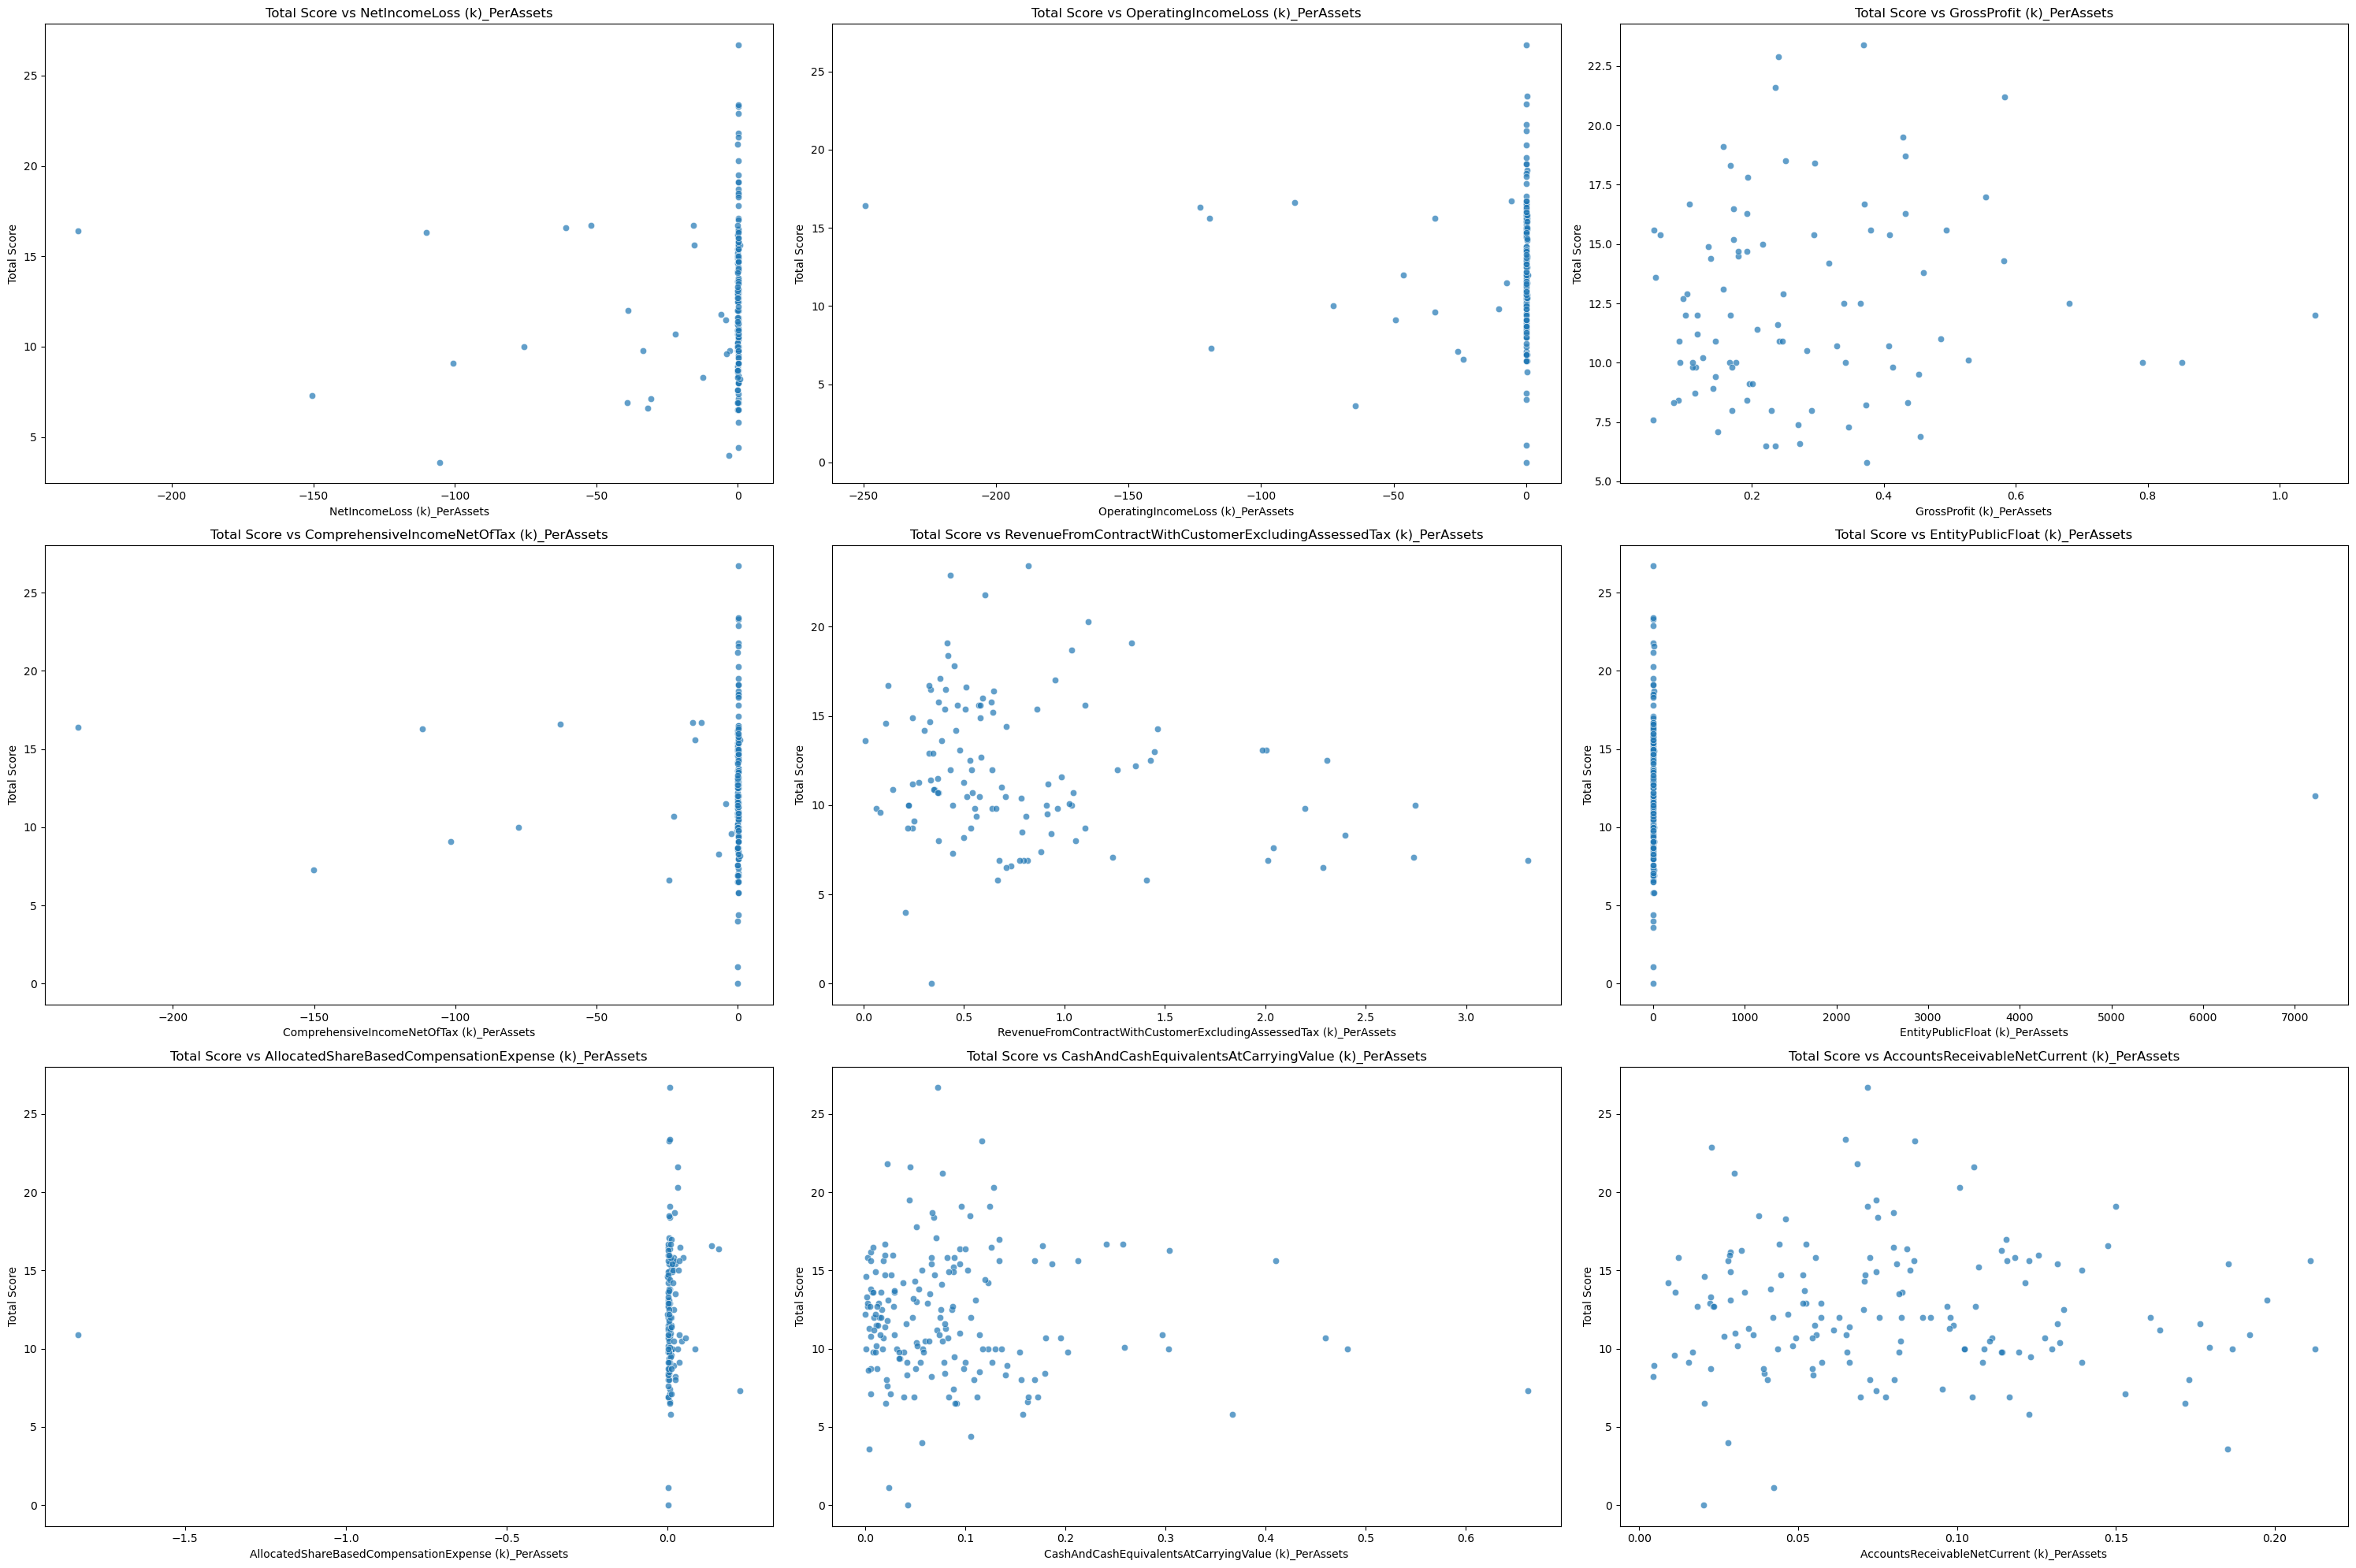

In [20]:
# List of standardized financial indicator columns
standardized_columns = [f"{col}_PerAssets" for col in financial_columns]

# Correlation Analysis
# Compute correlations between standardized financial indicators and Total Score
correlation_data = data[standardized_columns + ['Total']].corr()
correlations = correlation_data['Total'].drop('Total')

# Visualize correlations using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Correlation Between Standardized Financial Indicators and Total Score")
plt.show()

# Feature Pairings: Scatter plots for each financial indicator vs Total Score
plt.figure(figsize=(30, 20))
for i, col in enumerate(standardized_columns, start=1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[col], y=data['Total'], alpha=0.7)
    plt.title(f"Total Score vs {col}")
    plt.xlabel(col)
    plt.ylabel("Total Score")

plt.tight_layout()
plt.show()

### Differences in Financial Indicator Means by CEO Gender

## Text Analysis and Feature Engineering

### Keyword Analysis: Comparing Policies and Actions Across Workplace and Supply Chain Contexts

To better analyze different key features in workplace and supply chain, we select following variables:

**Work Place**:

GPG-C01.EA-Evidence: Evidence of whether the company collects sex-disaggregated pay data in the workplace.

HSW-D01.EA-Evidence: The company has a publicly available policy statement committing it to respect the health and safety of its employees.

**Supply Chain**:

CAP-A07.EA-Evidence: The company screens for gender-related issues among its suppliers as part of its audit process.

SHS-D02.EA-Evidence: Evidence of health and safety measures for workers in the supply chain.

First, we choose to retain only relevant columns for analysis.

In [137]:
# Filter rows where 'has_evidence' is 1 for both workplace and supply chain variables
workplace_columns = ['GPG-C01.EA-Evidence', 'GPG-C01.EA-Evidence-has_evidence',
                     'HSW-D01.EA-Evidence', 'HSW-D01.EA-Evidence-has_evidence']
supply_chain_columns = ['CAP-A07.EA-Evidence', 'CAP-A07.EA-Evidence-has_evidence',
                        'SHS-D02.EA-Evidence', 'SHS-D02.EA-Evidence-has_evidence']

# Filter rows
workplace_df = data[data['GPG-C01.EA-Evidence-has_evidence'] == 1][workplace_columns]
workplace_df = workplace_df[workplace_df['HSW-D01.EA-Evidence-has_evidence'] == 1][workplace_columns]
supply_chain_df = data[data['CAP-A07.EA-Evidence-has_evidence'] == 1][supply_chain_columns]
supply_chain_df = supply_chain_df[supply_chain_df['SHS-D02.EA-Evidence-has_evidence'] == 1][supply_chain_columns]

Next, we use term frequency analysis on the filtered text to identify commonly used keywords. And we use wordcload plots and bar plots to visualize the results.

In [138]:
# Keyword extraction
def extract_keywords(text_series):
    vectorizer = CountVectorizer(max_features=20)
    X = vectorizer.fit_transform(text_series)
    keywords = vectorizer.get_feature_names_out()
    frequencies = X.toarray().sum(axis=0)
    return dict(zip(keywords, frequencies))

# Extract keywords from explanations
workplace_keywords = extract_keywords(workplace_df['GPG-C01.EA-Evidence'].dropna())
supply_chain_keywords = extract_keywords(supply_chain_df['CAP-A07.EA-Evidence'].dropna())

In [139]:
# Visualization
def plot_wordcloud(keyword_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

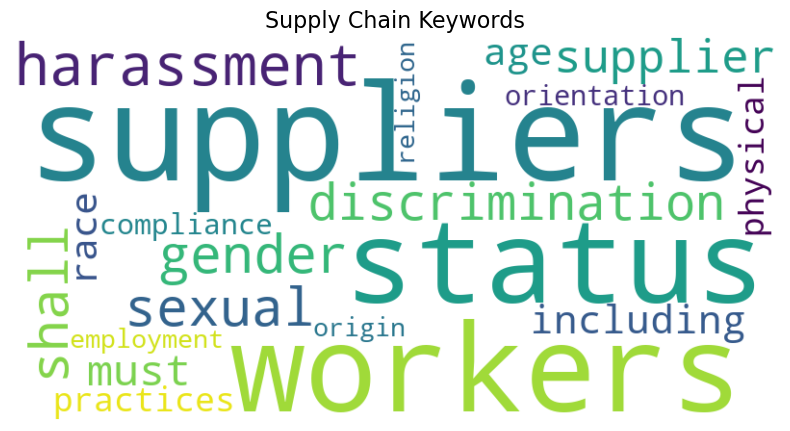

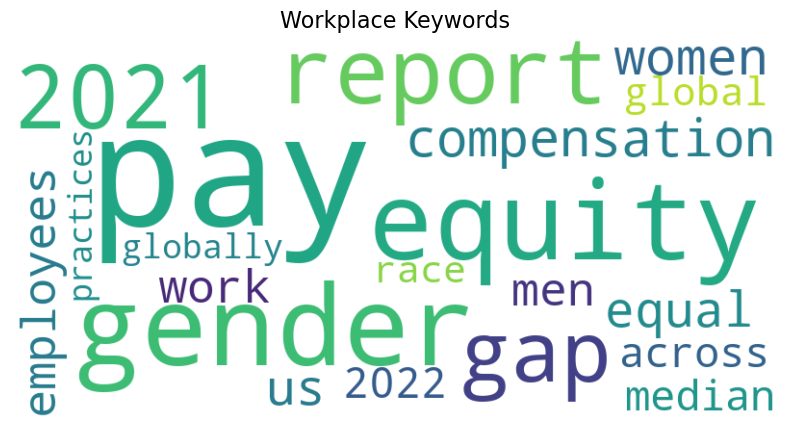

In [140]:
# Wordcloud for supply chain
plot_wordcloud(supply_chain_keywords, "Supply Chain Keywords")

# Wordcloud for workplace
plot_wordcloud(workplace_keywords, "Workplace Keywords")

In [141]:
#  Bar plot visualization
def plot_bar_chart(keyword_dict, title):
    # Sort the keywords by frequency in descending order
    sorted_keywords = sorted(keyword_dict.items(), key=lambda x: x[1], reverse=True)
    keywords = [item[0] for item in sorted_keywords]
    frequencies = [item[1] for item in sorted_keywords]
    plt.figure(figsize=(10, 5))
    plt.barh(keywords, frequencies, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency")
    plt.ylabel("Keywords")
    plt.gca().invert_yaxis()
    plt.show()

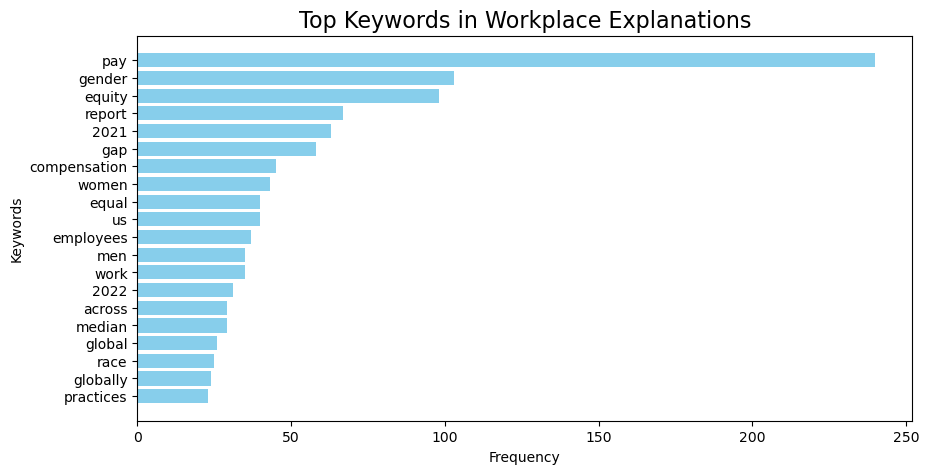

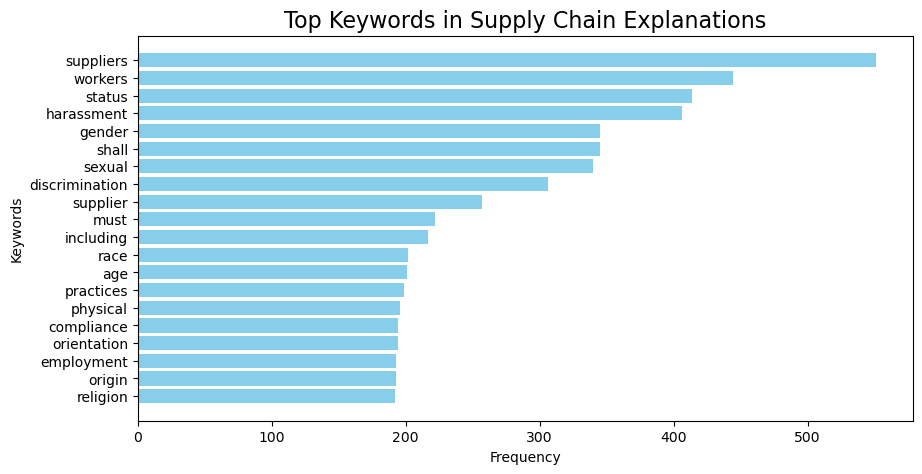

In [142]:
# Bar chart for workplace
plot_bar_chart(workplace_keywords, "Top Keywords in Workplace Explanations")

# Bar chart for supply chain
plot_bar_chart(supply_chain_keywords, "Top Keywords in Supply Chain Explanations")

**Visual Observations**:

The keywords in workplace explanations includes "pay", "compensation", "global" and "equity". In contrast, supply chain explanations highlight terms like "suppliers", "workers", "status" and "compliance".

**Key Insights**:

We can find that workplace explanations mainly focus on policies for accountability and equity. In contrast, supply chain explanations focus on action , highlighting compliance, addressing operational challenges, and resolving gender-related issues. This distinction shows that workplace efforts are primarily policy-driven, while supply chain initiatives prioritize actionable measures.

### Sentiment Analysis: Focus on Violence and Harassment Prevention

To better apply sentiment analysis, we select following variables:

VHP-E01.EA-Evidence: The company has publicly available policies in place regarding violence and harassment in the workplace (e.g., zero tolerance policy, safe transport policy, etc.).

We filtered the words 'violence' and 'harassment' to avoid their inherently negative sentiment.

In [143]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [144]:
filtered_df = data[data['VHP-E01.EA-Evidence-has_evidence'] == 1]

# Extract explanation text
combined_text = filtered_df['VHP-E01.EA-Evidence'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Remove "harassment" and "violence" from combined_text
combined_text = filtered_df['VHP-E01.EA-Evidence'].fillna('').apply(
    lambda x: re.sub(r'\b(harassment|violence)\b', '', x, flags=re.IGNORECASE) if isinstance(x, str) else x
)

In [145]:
# Perform sentiment analysis
def analyze_sentiment(text_data):
    sentiments = []
    for text in text_data:
        if pd.notna(text):
            score = analyzer.polarity_scores(text)
            sentiments.append(score['compound'])  # Compound sentiment score
        else:
            sentiments.append(0)  # Neutral for missing text
    return sentiments

Next, we analyze sentiment for text and categorize them, After that, we visualize the results.

In [146]:
# Analyze sentiment
sentiment_scores = analyze_sentiment(combined_text)

In [147]:
# Categorize sentiment
def categorize_sentiments(sentiment_scores):
    categories = []
    for score in sentiment_scores:
        if score > 0:
            categories.append('Positive')
        elif score < 0:
            categories.append('Negative')
        else:
            categories.append('Neutral')
    return categories

In [148]:
# Categorize sentiment
sentiment_categories = categorize_sentiments(sentiment_scores)

In [149]:
# Visualization
def plot_sentiment_distribution(sentiment_categories, title):
    sentiment_counts = pd.Series(sentiment_categories).value_counts()
    sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'], figsize=(8, 5))
    plt.title(title)
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.show()

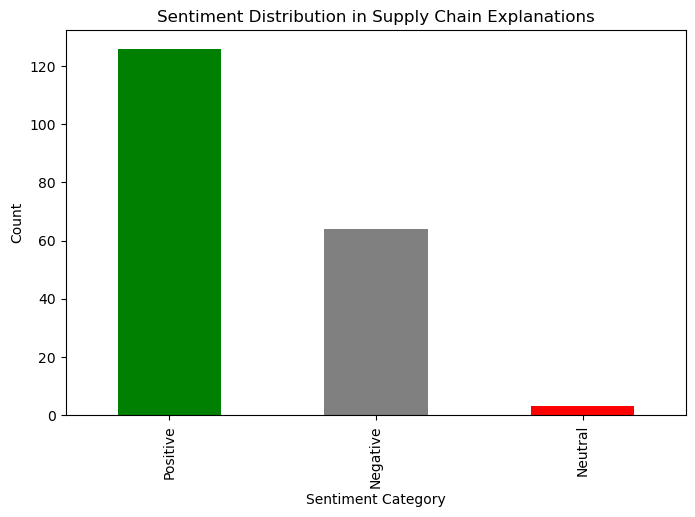

In [150]:
# Visualize results
plot_sentiment_distribution(sentiment_categories, 'Sentiment Distribution in Supply Chain Explanations')

**Visual Observations**:

The sentiment distribution predominantly shows positive entries, with fewer negative and very few neutral sentiments.

**Key Insights**:

The predominance of positive sentiment suggests an emphasis on proactive measures and commitment to addressing sensitive issues constructively. Negative sentiments, while present, may reflect acknowledgment of challenges or areas requiring improvement, indicating transparency. After analysis, we can find that for a heavy topic, such as Violence and Harassment, most companies need to emphasis on responsibility and accountability in the text, and show their positive attitude.

## Topic Distribution Across Industries: Gender-responsive human rights due diligence process

To better prepare for topic modeling, we select following variables:

GDD-A04.EA-Evidence: The company discloses what gender-related human rights impacts it has assessed and prioritised as being salient (i.e. most severe and potentially irremediable if not addressed). 

We choose this variable to analyze because we want to learn more about how different industries prioritize and address specific aspects of human rights and supply chain challenges.

We tokenize and filter the data first.

In [186]:
def preprocess_text(text_data):
    # Tokenize the text (splitting into words)
    tokenized_text = word_tokenize(text_data.lower())  # Convert to lowercase to standardize
    
    # Remove punctuation (if necessary)
    tokenized_text = [word for word in tokenized_text if word not in string.punctuation]
    
    # Return the cleaned tokenized text
    return tokenized_text

# Filter data based on evidence
rights_df = data[data['GDD-A04.EA-Evidence-has_evidence'] == 1]

# Group data by 'Industry'
industry_grouped_df = rights_df.groupby('Industry')['GDD-A04.EA-Evidence'].apply(lambda x: ' '.join(x)).reset_index()


# Preprocess text data for each industry
industry_grouped_df['ProcessedText'] = industry_grouped_df['GDD-A04.EA-Evidence'].apply(preprocess_text)

In [187]:
# Join tokenized text into a single string for each row
industry_grouped_df['ProcessedTextStr'] = industry_grouped_df['ProcessedText'].apply(lambda x: ' '.join(x))

Next, we choose the optimal number of topics and run the modeling.

In [ ]:
# Vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(industry_grouped_df['ProcessedTextStr'])

# Function to compute perplexity
def compute_perplexity(lda_model, X):
    return lda_model.perplexity(X)

# List to store perplexity scores
perplexities = []
topic_range = range(2, 11)  # Try 2 to 10 topics

# Train LDA and compute perplexity for different topic numbers
for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=5000)
    lda.fit(X)
    
    # Compute perplexity (lower is better)
    perplexity = compute_perplexity(lda, X)
    perplexities.append(perplexity)

optimal_num_topics = topic_range[np.argmin(perplexities)]

In [193]:
# Train the LDA model with the optimal number of topics
lda = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=5000) 
lda.fit(X)

# Output the topics
for index, topic in enumerate(lda.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])

Topic #0:
['human', 'factory', 'factories', 'conduct', 'trafficking', 'chain', 'supply', 'act', 'webpage', 'forced']
Topic #1:
['rights', 'human', 'risks', 'risk', 'suppliers', 'business', 'report', '2021', 'assessment', 'including']


We using stacked bar chart to analyze the distribution of topics accross industries.

<Figure size 1000x600 with 0 Axes>

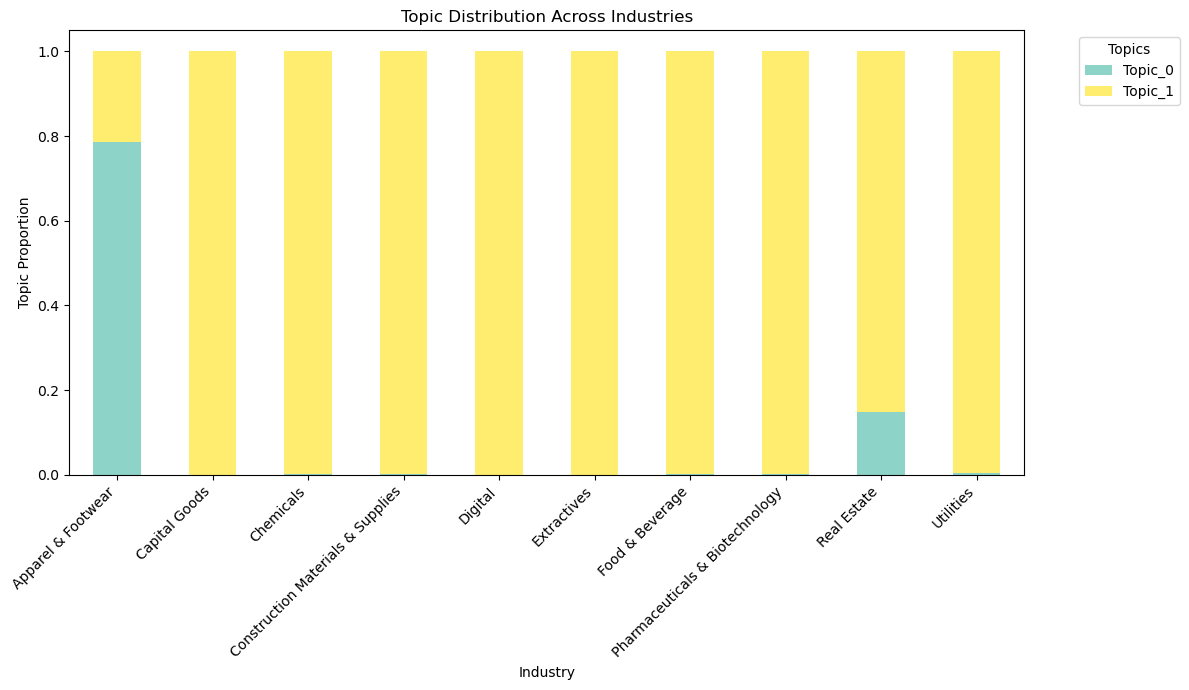

In [199]:
# Get the topic distribution for each document
topic_distribution = lda.transform(X)

# Add the topic distribution to the dataframe (one column per topic)
topic_columns = [f"Topic_{i}" for i in range(optimal_num_topics)]
topic_distribution_df = pd.DataFrame(topic_distribution, columns=topic_columns)

# Ensure industry_grouped_df and topic_distribution_df have the same number of rows
# Reset the index for both DataFrames to ensure they align
industry_grouped_df = industry_grouped_df.reset_index(drop=True)  # Reset index to align
topic_distribution_df = pd.DataFrame(topic_distribution, columns=topic_columns)

# Double-check the number of rows before concatenating
assert len(industry_grouped_df) == len(topic_distribution_df), "Row numbers don't match!"

# Combine the dataframes
df_with_topics = pd.concat([industry_grouped_df, topic_distribution_df], axis=1)

# Aggregate topic distributions by industry
industry_topic_dist = df_with_topics.groupby('Industry')[topic_columns].mean()

# Plot the topic distributions across industries (stacked bar chart)
plt.figure(figsize=(10, 6))
industry_topic_dist.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')
plt.title('Topic Distribution Across Industries')
plt.xlabel('Industry')
plt.ylabel('Topic Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Visual Observations**:

Topic #0, related to supply chain issues and human trafficking, is most prevalent in manufacturing, retail, and wholesale industries. Topic #1, focusing on human rights assessments and risk reporting, shows a more balanced distribution across industries, highlighting its relevance in broader corporate governance.

**Key Insights**:

Topic #0, which addresses supply chain issues like forced labor and trafficking, is more significant in industries such as manufacturing and retail, where these issues are more likely to arise. Topic #1, focused on human rights reporting and risk assessment, is more evenly distributed across industries, reflecting the growing importance of human rights evaluation in corporate governance across sectors.

### Keyword Network Analysis: Unveiling the Structure of Grievance Mechanisms

To better prepare for network analysis, we select following variables about grievance mechanisms:

GM-A05.EA-Evidence: The company has a gender-responsive mechanism through which employees can report grievances. 

GM-A05.EA-Evidence: The company has one or more channel(s)/mechanism(s), or participates in a shared mechanism, accessible to all external individuals and communities who may be adversely impacted by the company (or individuals or organisations acting on their behalf or who are otherwise in a position to be aware of adverse impacts), to raise complaints or concerns.

GM-A05.EC-Evidence: The company collects, analyses and monitors sex-disaggregated grievance data (e.g. number of grievances reported, number of grievances remediated).


First, combined evidence columns into a single text column.

In [ ]:
# Filter data for rows with evidence for all three variables
filtered_df = data[
    (data['GM-A05.EA-Evidence-has_evidence'] == 1) |
    (data['GM-A05.EB-Evidence-has_evidence'] == 1) |
    (data['GM-A05.EC-Evidence-has_evidence'] == 1)
][['GM-A05.EA-Evidence', 'GM-A05.EA-Evidence', 'GM-A05.EC-Evidence']]

# Drop rows where all three evidence fields are NaN (no data available for any variable)
filtered_df = filtered_df.dropna(how='all', subset=['GM-A05.EA-Evidence', 'GM-A05.EB-Evidence', 'GM-A05.EC-Evidence'])

Next, computed a co-occurrence matrix by multiplying the term-document matrix with its transpose, and then visualize them.

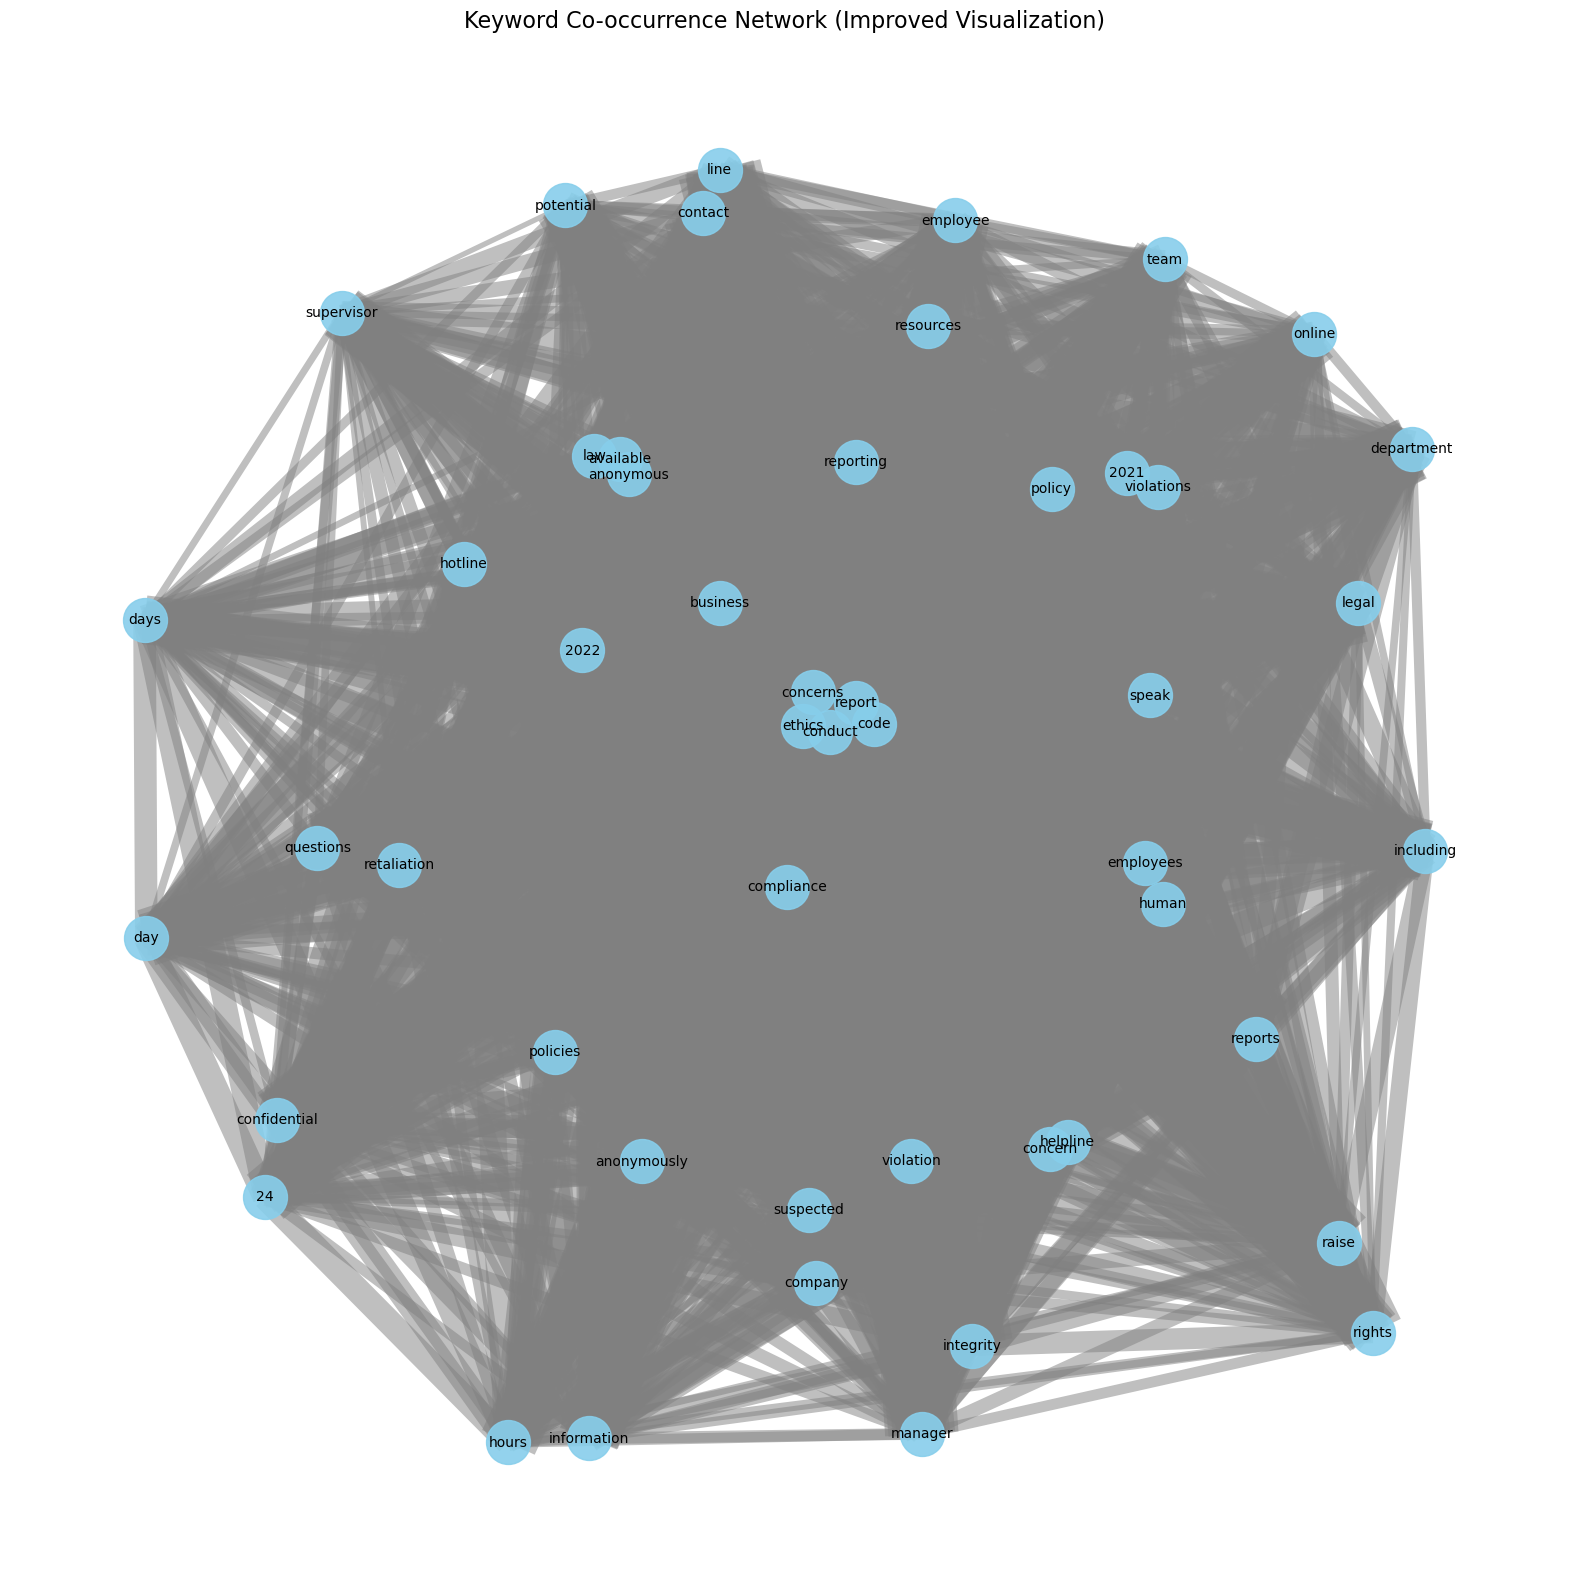

In [135]:
# Combine evidence columns into a single text column
filtered_df['CombinedText'] = filtered_df['GM-A05.EA-Evidence'].fillna('') + ' ' + \
                              filtered_df['GM-A05.EB-Evidence'].fillna('') + ' ' + \
                              filtered_df['GM-A05.EC-Evidence'].fillna('')

# Tokenize and extract keywords using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Adjust max_features as needed
X = vectorizer.fit_transform(filtered_df['CombinedText'])

# Get feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Construct a co-occurrence matrix
cooccurrence_matrix = (X.T @ X).toarray()  # Multiply term-document matrix by its transpose
cooccurrence_df = pd.DataFrame(cooccurrence_matrix, index=keywords, columns=keywords)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes and edges from the co-occurrence matrix
for i, word in enumerate(keywords):
    for j, cooc in enumerate(cooccurrence_matrix[i]):
        if i != j and cooc > 0:  # Exclude self-loops
            G.add_edge(keywords[i], keywords[j], weight=cooc)

# Visualization of the network
plt.figure(figsize=(20, 20))


# Use spring layout with adjusted spacing
pos = nx.spring_layout(G, seed=5000, k=0.2)

# Draw nodes with adjusted size and color
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', alpha=0.9)

# Draw edges with transparency based on weight
edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color='gray',
    alpha=0.5, 
    width=[d['weight'] / 20 for (u, v, d) in G.edges(data=True)]
)

# Add labels with adjusted font size
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add title and adjust layout
plt.title("Keyword Co-occurrence Network (Improved Visualization)", fontsize=16)
plt.axis('off')  # Turn off axis
plt.show()


**Visual Observations**:

The network highlights strong connections between keywords like "complaint," "grievance," "report," and "rights," showing their central role in grievance mechanisms. Terms such as "procedure" and "access" suggest a focus on process and accessibility, while some isolated keywords point to less frequent but relevant topics.

**Key Insights**:

Grievance mechanisms are closely tied to reporting rights violations and ensuring accessible procedures. The emphasis on "procedure" and "access" reflects a priority on usability, fairness and formation, while less frequent terms hint at more specialized concerns or contexts.